In [1]:
import pickle
import baltic as bt
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import patches as patches
from collections import defaultdict
%matplotlib inline

common_names = pickle.load(open('../../data/hosts/common_names.p', 'rb'))
sizes = pickle.load(open('../sizes.p', 'rb'))
colors = pickle.load(open('../colors.p', 'rb'))

In [2]:
cutoff = 3.0
treepath = '../../data/hosts/host_mtdna.nexus'
hosttree = bt.loadNexus(treepath,tip_regex='\|([0-9]+\-[0-9]+\-[0-9]+)',absoluteTime=False)
rotate_indices = [16848, 16849, 28134, 2856, 2857, 38385, 5284, 28135, 28570]
for k in hosttree.nodes:
    if k.index in rotate_indices:
        k.rotate()

hosttree.drawTree()

known = [('Chimp_ptt', 'Human'), ('Chimp_ptt', 'Gorilla'), ('Gorilla', 'Human'), ('Sooty_Mangabey', 'Human'), ('Vervet', 'Baboon')]
interesting = [('Tantalus_Monkey', 'Sooty_Mangabey'), ('Tantalus_Monkey', 'Chimp_pts'), ('Tantalus_Monkey', 'Mona_Monkey'), ('Tantalus_Monkey', 'Red-capped_Mangabey'), ('Mona_Monkey', 'Chimp_pts'), ('Chimp_pts', 'Chimp_ptt')]


Tree height: 0.386005
Tree length: 2.500639

Tree is strictly bifurcating = True

Tree is multitype = False

Tree has annotations = True

Numbers of objects in tree: 47 (23 nodes and 24 leaves)



In [3]:
AR = pd.read_csv('/Users/Sidney/Dropbox/siv-manuscript/beast/main/discreteTraits/results/discreteTraits_2016-10-25_actualRates.csv', index_col=0, header=0).to_dict(orient='index')
BF = pd.read_csv('/Users/Sidney/Dropbox/siv-manuscript/beast/main/discreteTraits/results/discreteTraits_2016-10-25_bf.csv', index_col=0, header=0).to_dict(orient='index')

transmissions = defaultdict(list) # {from: [(to, bf, ar), .... ], ...}
for from_host, to_dict in BF.iteritems():
    for to_host, bf in to_dict.iteritems():
        if bf >= cutoff*12: # Account for the 12 segments' statistical nonindependence.
            transmissions[from_host].append((to_host, bf, AR[from_host][to_host]))
        else:
            continue

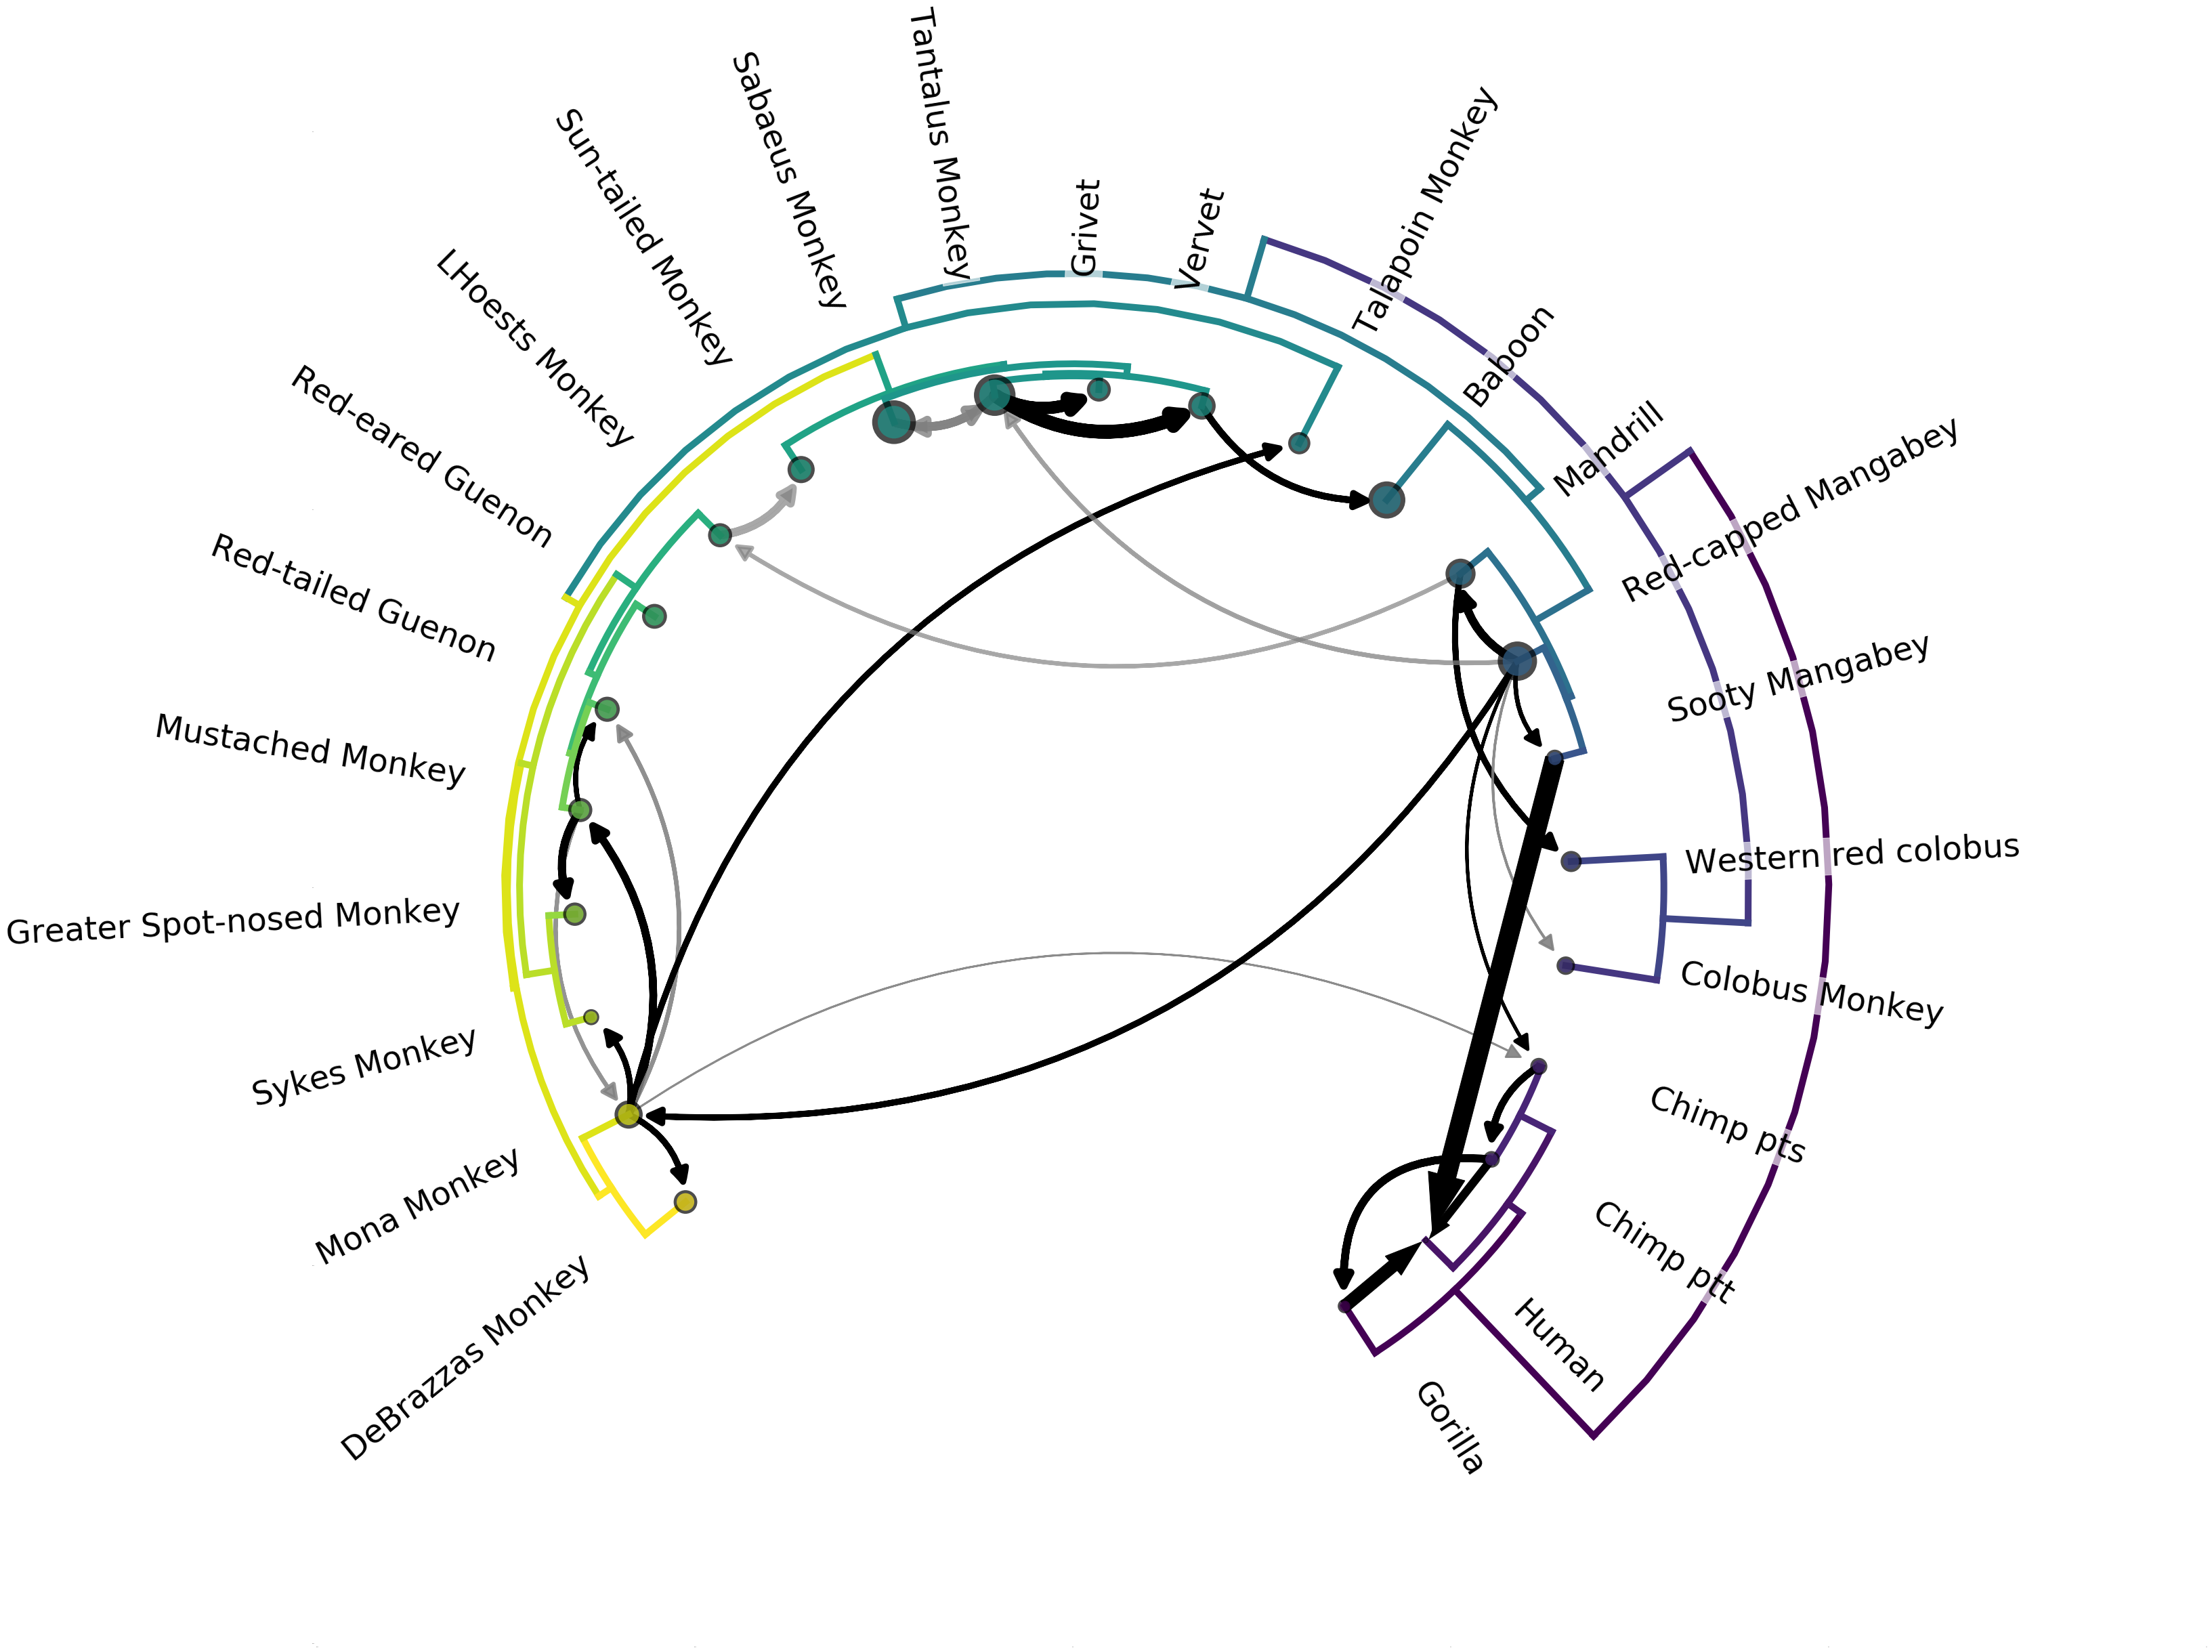

In [4]:
fig,ax = plt.subplots(figsize=(50,50),facecolor='w')

branchWidth=10 

inwardSpace=-0.01
gap=0.8 ## determines how much of their allocated space along the circle a tree uses

circFrac=1.0
startFrom=np.pi ## start at some point along the circle

controlDepth=500*hosttree.treeHeight 

labelcoordinates = defaultdict(tuple)
nodecoordinates = defaultdict(tuple)

baseCircle=2*np.pi*startFrom ## tree starts here along the circle

leaves=[w.name for w in hosttree.Objects if isinstance(w,bt.leaf)] ## fetch names of tips in the tree
leafCount=len(leaves) ## count leaves in the tree

for k in hosttree.Objects: ## iterate through objects in the tree
    y=k.y ## get y position of current object
    x=k.height*1.7 ## get x position of current object
    xp=k.parent.height*1.7 ## get x position of current object's parent

    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp=x

    ## once a tree is circular (or radial) the x coordinate is transformed into a coordinate along a circle of a bigger or smaller diameter
    # this is done by starting from the inward space, and plotting things deeper in time outwards
    xc=inwardSpace+(x/controlDepth) ## transform x coordinate
    xpc=inwardSpace+(xp/controlDepth) ## transform x parent's coordinate

    ## circularisation of the tree depends on transforming y coordinates into positions along a circle
    # this is done by specifying a position that is a fraction along a circle of length 2*pi
    # such coordinates are then plotted using sin(y) and cos(y) to get x and y coordinates along a circle, respectively
    yc=baseCircle+circFrac*np.pi*2*(y/float(leafCount))*gap ## transform y coordinate

    if k.traits.has_key('host'): ## if tree has host trait - colour accordingly        
        c = colors[k.traits['host']]
    else: ## otherwise - black
        c='k'

    if isinstance(k,bt.leaf): ## if leaf...
        s=sizes[common_names[k.traits['host']]]*20000
        nodecoordinates[common_names[k.traits['host']]] = (np.sin(yc)*xc, np.cos(yc)*xc)
        labelcoordinates[common_names[k.traits['host']]] = (np.sin(yc)*(xc-0.0015), np.cos(yc)*(xc-0.0015), np.arctan((np.cos(yc)*(xc))/(np.sin(yc)*(xc)))*(180.0/np.pi))

        ax.scatter(np.sin(yc)*xc,np.cos(yc)*xc,s=s,facecolor=c,edgecolor='none',zorder=11, alpha=0.7) ## plot circle for every tip, notice that coordinates that were y coordinates are now transformed with sin and cos and previous x coordinate is used to scale the circle up
        ax.scatter(np.sin(yc)*xc,np.cos(yc)*xc,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10, alpha=0.7) ## plot black circle underneath

    elif isinstance(k,bt.node): ## if node...
        yl=k.children[-1].y ## fetch first child y coordinate
        yr=k.children[0].y ## fetch last child y coordinate

        ycl=baseCircle+circFrac*np.pi*2*(yl/float(leafCount))*gap ## transform coordinates of first child
        ycr=baseCircle+circFrac*np.pi*2*(yr/float(leafCount))*gap ## transform coordinates of last child

        ybar=np.linspace(ycl,ycr,15) ## create a curved bar
        
        ax.plot(np.sin(ybar)*xc,np.cos(ybar)*xc,lw=branchWidth,color=c,ls='-',zorder=9) ## plot curved bar at the base of a node

    ax.plot([np.sin(yc)*xc,np.sin(yc)*xpc],[np.cos(yc)*xc,np.cos(yc)*xpc],lw=branchWidth,color=c,ls='-',zorder=9) ## plot ancestral branch

rtalign = ['Sun-tailed_Monkey', 'Sabaeus_Monkey','Tantalus_Monkey', 'Vervet', 'Grivet', 'Mona_Monkey', 'DeBrazzas_Monkey', 'Mustached_Monkey', 'Red-tailed_Guenon', 'Red-eared_Guenon', 'LHoests_Monkey', 'Sykes_Monkey', 'Greater_Spot-nosed_Monkey']
leftalign= [ 'Talapoin_Monkey', 'Western_red_colobus', 'Colobus_Monkey', 'Mandrill', 'Sooty_Mangabey', 'Red-capped_Mangabey', 'Gorilla', 'Human', 'Chimp_ptt', 'Chimp_pts']
misaligned = ['Sun-tailed_Monkey', 'Sabaeus_Monkey', 'Red-tailed_Guenon', 'Red-eared_Guenon', 'LHoests_Monkey', 'Baboon',  'Tantalus_Monkey', 'Mustached_Monkey', 'Grivet', 'Vervet', 'Talapoin_Monkey', 'Sooty_Mangabey', 'Red-capped_Mangabey', 'Mandrill']

for host, (tip_x, tip_y, angle) in labelcoordinates.iteritems():
    if host in misaligned:
        if host in rtalign:
            t=ax.text(tip_x, tip_y, host.replace('_', ' '), fontsize=48, ha='right', va='bottom', zorder=100, rotation=angle)
        else:
            t=ax.text(tip_x, tip_y, host.replace('_', ' '), fontsize=48, ha='left', va='bottom', zorder=100, rotation=angle)        
    else:
        if host in rtalign:
            t=ax.text(tip_x, tip_y, host.replace('_', ' '), fontsize=48, ha='right', va='baseline', zorder=100, rotation=angle)
        else:
            t=ax.text(tip_x, tip_y, host.replace('_', ' '), fontsize=48, ha='left', va='baseline', zorder=100, rotation=angle)
    t.set_bbox(dict(color='white', alpha=0.65))

maxar = max([[ i[2] for i in to_list] for from_host, to_list in transmissions.items()])[0]
maxbf = np.log(max([[ i[1] for i in to_list] for from_host, to_list in transmissions.items()])[0])

flip = ['Sooty_Mangabey', 'Chimp_ptt', 'Chimp_pts', 'Human', 'Gorilla', 'Mona_Monkey', 'DeBrazzas_Monkey', 'Sykes_Monkey', 'Mona_Monkey', 'Mustached_Monkey', 'Red-tailed']

for from_host, to_list in transmissions.iteritems():
    for to_host, bf, ar in to_list:
        if bf >= 120.0:
            c = 'k'
            a = 1.0
        else:
            c = 'gray'
            a = (float(bf)/240.0) + 0.5
        
        x, y = nodecoordinates[from_host]
        to_x, to_y = nodecoordinates[to_host]
                   
        w = float(ar)*6

        if to_host == 'Human':
            ax.arrow(x, y, (to_x-x)*.95, (to_y-y)*.98, 
                     width = float(ar)/float(maxar*4000), 
                     alpha=a, 
                     head_width = float(ar)/float(maxar*2000), 
                     length_includes_head=True, color=c)    
        else:
            if to_x > x:
                r = 0.3
            else:
                r = -0.3

            if from_host in flip:
                r = -1.*r
            if from_host == 'Chimp_ptt' and to_host == 'Gorilla':
                r = 0.6
            if from_host == 'Mustached_Monkey' and to_host == 'Mona_Monkey':
                r = -1.*r

            style = patches.ArrowStyle("Simple", head_length=20, head_width=20)

            p = patches.FancyArrowPatch((x, y), (to_x, to_y), 
                                        connectionstyle='arc3, rad=%f'%r, color=c, shrinkB=30, 
                                        alpha=a, aa=True, lw=w,
                                        arrowstyle=style)
            ax.add_patch(p)

ax.spines['top'].set_visible(False) ## no axes
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.tick_params(axis='x',labelsize=0,size=0) ## no labels
ax.tick_params(axis='y',labelsize=0,size=0)

ax.set_aspect(1) ## aspect set to 1 for proper circular plot
plt.show()

# plt.savefig('cst_known.png', bbox_inches='tight')


### Figure 3: Most lentiviruses are the product of ancient cross-species transmissions.  
The phylogeny of the host species' mitochondrial genomes forms the outer circle. Arrows represent transmission events inferred by the model with Bayes' factor (BF) >= 3.0; black arrows have BF >= 10, with opacity of gray arrows scaled for BF between 3.0 and 10.0. Width of the arrow indicates the frequency of transmission (actual rates = rates * indicators). Transmissions from chimps to humans; chimps to gorillas; gorillas to humans; sooty mangabeys to humans; sabaeus to tantalus; and vervets to baboons have been previously documented. To our knowledge, all other transmissions illustrated are novel identifications.